In [100]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm


import sklearn, sklearn.linear_model, sklearn.metrics, sklearn.pipeline,sklearn.ensemble

import matplotlib
import scipy.stats

matplotlib.rcParams.update({'font.size': 20})

model_colors = {'Species-aware':"#E69F00",'Species-agnostic':"#56B4E9",
                'Species-aware-tempscale':"#E69F00",'Species-agnostic-tempscale':"#56B4E9",
                'DNABERT':"#CC79A7", '11-mer':"#F0E442",'PhyloP100':"#0072B2",'PhyloP240':"#D55E00"}

In [135]:
#10th and 90th percentiles of reference score

percentiles_models = {"Species-agnostic":[0.166,0.552],"Species-aware":[0.167,0.552],
                      "DNABERT":[0.16,0.689],"11-mer":[0.166,0.489],"PhyloP100":[-0.877,2.03],"PhyloP241":[-0.912,3.04],} 

#1st and 99th percentiles of reference score

#percentiles_models = {"Species-agnostic":[0.0498,0.98],"Species-aware":[0.0544,0.982],"DNABERT":[0.0379,0.985],"11-mer":[0.0569,0.842],
#                      "PhyloP100":[-2.68,5.57],"PhyloP241":[-3.59,7.06],} 

In [122]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/MLM/'

In [123]:
utr_variants = pd.read_csv(data_dir + 'gnomAD/model_scores.tsv.gz', sep='\t')

In [124]:
#utr_variants = utr_variants[utr_variants.vartype=='SNP']

In [125]:
utr_variants.loc[utr_variants.AF_popmax=='.','AF_popmax'] = np.NaN
utr_variants.AF_popmax = utr_variants.AF_popmax.astype(float)

In [136]:
def get_contig_table(model, min_AF_common = 0.05, max_AC_rare = 1):
    if 'Species' in model or model=='DNABERT':
        score = utr_variants[f'{model}_ref']
    else:
        score = -utr_variants[model]

    #perc_low = np.nanpercentile(score,1)
    #perc_high = np.nanpercentile(score,99)

    perc_low, perc_high = percentiles_models[model]

    rare_put_func = ((score<perc_low)&(utr_variants.AC<=max_AC_rare)).sum()
    rare_put_nonfunc = ((score>perc_high)&(utr_variants.AC<=max_AC_rare)).sum()
    
    common_put_func = ((score<perc_low)&(utr_variants.AF>min_AF_common)).sum()
    common_put_nonfunc = ((score>perc_high)&(utr_variants.AF>min_AF_common)).sum()

    contig_table = [[rare_put_func,common_put_func], [rare_put_nonfunc,common_put_nonfunc] ]

    return contig_table, score

In [137]:
models = ('PhyloP100','PhyloP241','Species-aware','Species-agnostic','DNABERT','11-mer')

In [138]:
odds_ratios = []

for model in models:
    contig_table, score[model] = get_contig_table(model)
    fisher_test = scipy.stats.fisher_exact(contig_table)
    print(model,contig_table, fisher_test)
    odds_ratios.append((model, fisher_test.statistic))

odds_ratios = pd.DataFrame(odds_ratios,columns=['model','OR']).sort_values(by='OR', ascending=False)
odds_ratios.loc[odds_ratios.model=='PhyloP241','model'] = 'PhyloP240'

PhyloP100 [[714400, 8324], [88782, 4814]] SignificanceResult(statistic=4.653615915473773, pvalue=0.0)
PhyloP241 [[968131, 14584], [53702, 1687]] SignificanceResult(statistic=2.085365063051982, pvalue=7.611048896838756e-146)
Species-aware [[651083, 17842], [228693, 10554]] SignificanceResult(statistic=1.6840579779789584, pvalue=0.0)
Species-agnostic [[656077, 17904], [225270, 10439]] SignificanceResult(statistic=1.6980883497344643, pvalue=0.0)
DNABERT [[169297, 4651], [50288, 2031]] SignificanceResult(statistic=1.470105432870074, pvalue=9.635732382590121e-44)
11-mer [[3273819, 77711], [0, 0]] SignificanceResult(statistic=nan, pvalue=1.0)


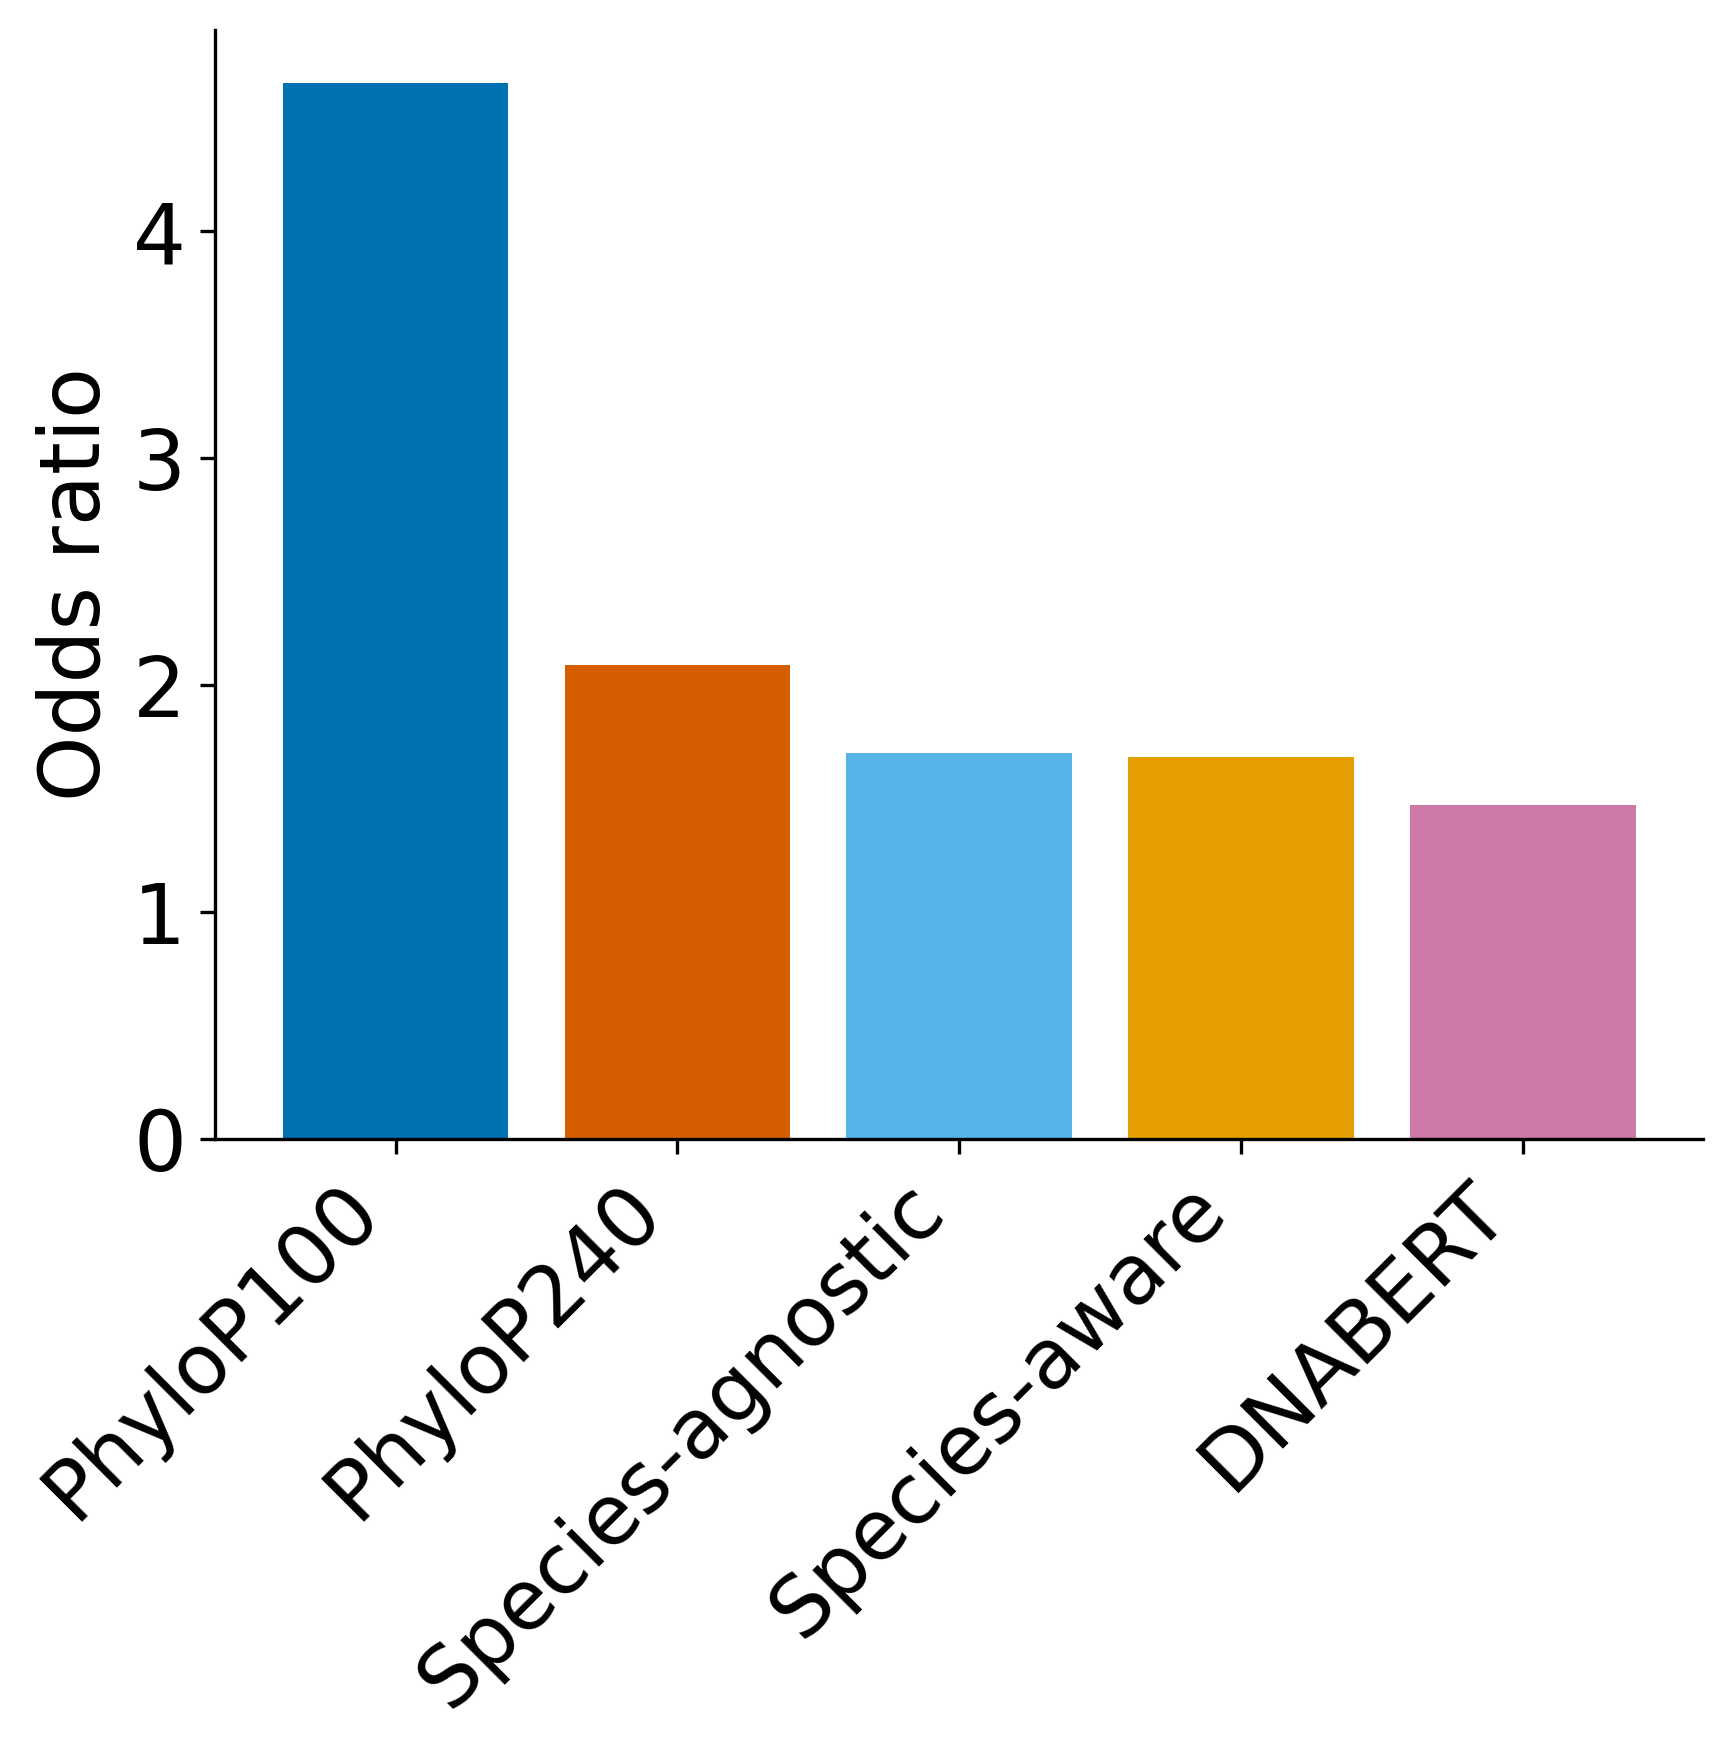

In [139]:
fig, ax = plt.subplots(dpi=300)

ax.bar(odds_ratios.model, odds_ratios.OR, color=odds_ratios.model.map(model_colors))
plt.xticks(rotation=45, ha="right")
ax.set_ylabel('Odds ratio')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_yscale('log')

#for model_idx, model in enumerate(models):
#    ax.text(model_idx-0.4, odds[model]+2, f'{odds[model]:.1f}')
#ax.set_ylim([0,260])

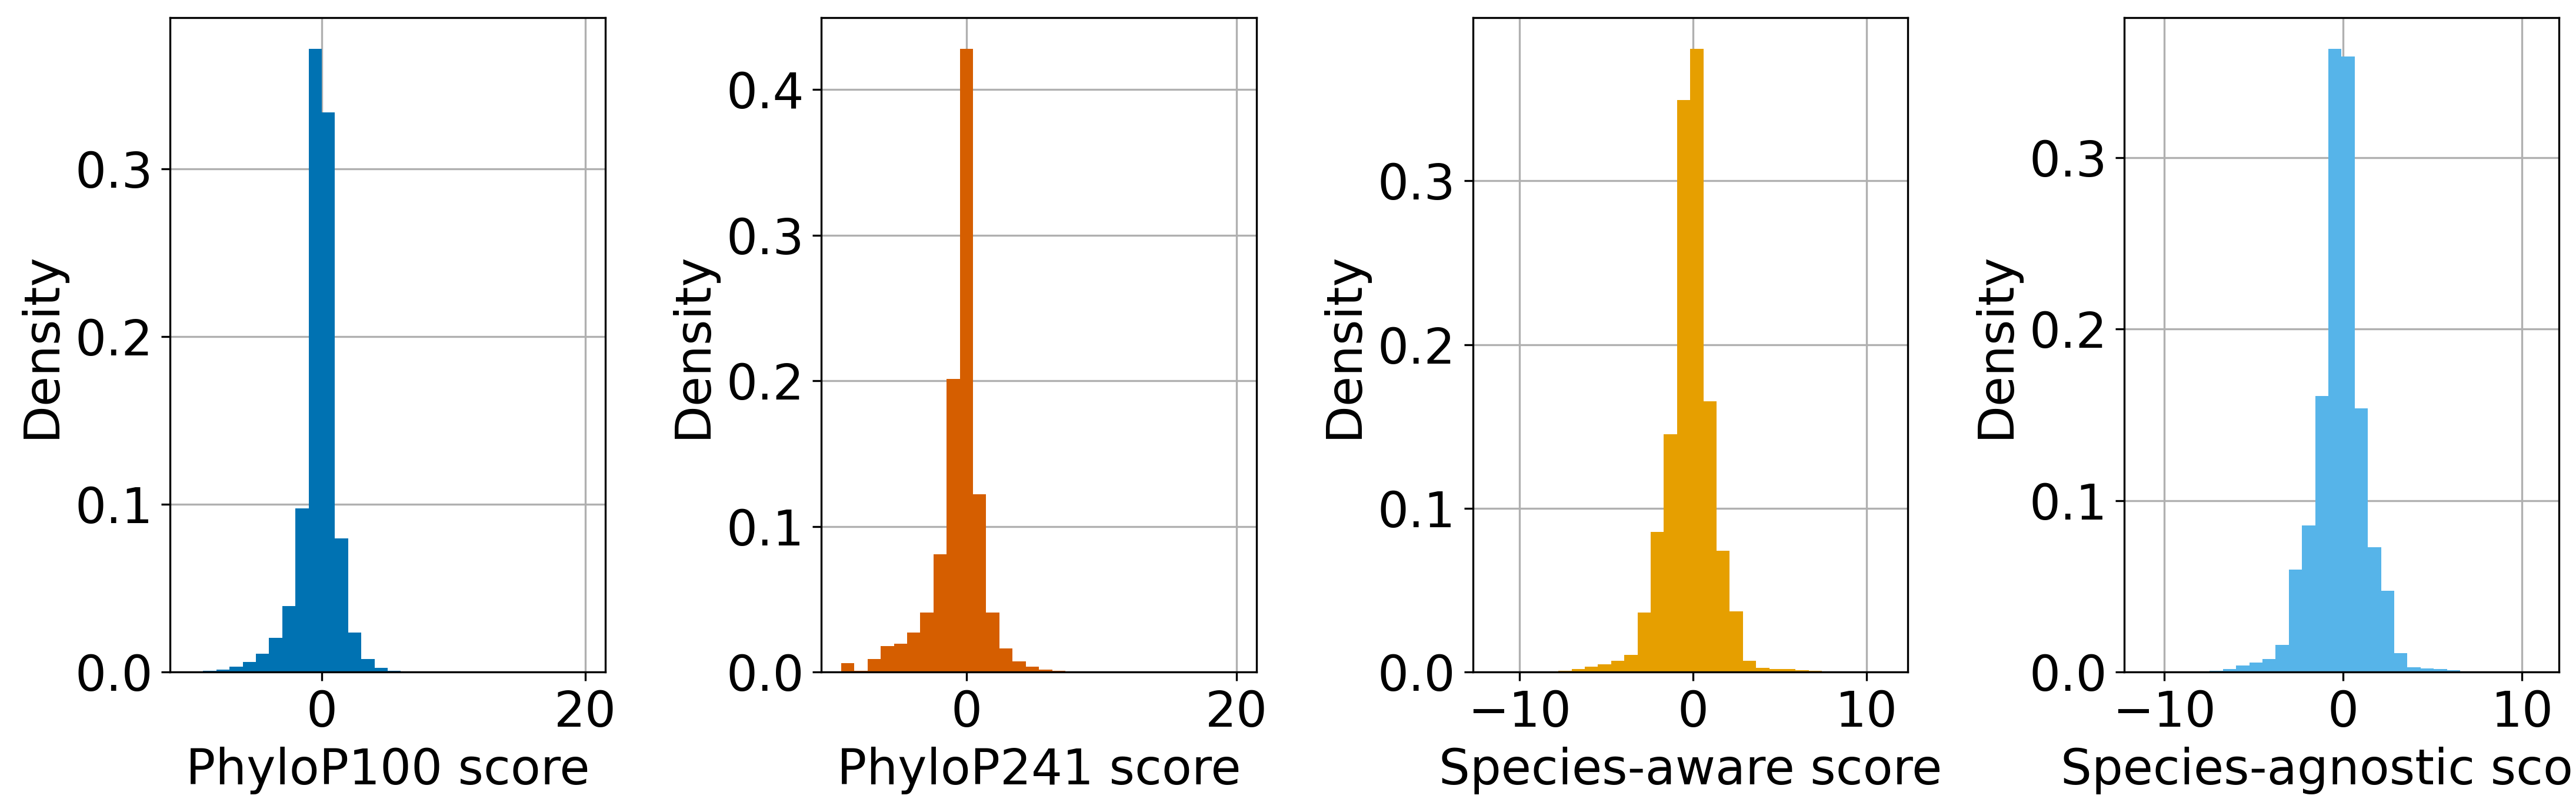

In [40]:
fig, axes = plt.subplots(1,4, figsize=(15,5), dpi=300)

for model, ax in zip(models,axes):
    ax.hist(score[model], density=True, color=model_colors[model.replace('PhyloP241','PhyloP240')], bins=30);
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_ylabel('Density')
    ax.set_xlabel(f'{model} score')


fig.tight_layout()

In [18]:
import itertools

for model1, model2 in itertools.combinations(models,2):
    mask = (~score[model1].isna()) & (~score[model2].isna())
    r = scipy.stats.pearsonr(score[model1][mask],score[model2][mask])
    print(model1, model2, r)

PhyloP100 PhyloP241 PearsonRResult(statistic=0.4876439029683529, pvalue=0.0)
PhyloP100 MLM PearsonRResult(statistic=-0.13913734561853747, pvalue=0.0)
PhyloP241 MLM PearsonRResult(statistic=-0.13405394454677214, pvalue=0.0)
